## Solution Approach:

### Used Input Dataset:
For the chosen Use Case analysis the kaggle input dataset was used:
https://www.kaggle.com/datasets/kaushal2896/airplane-accidents-severity-dataset 

The dataset consists of two files, both shared in the same folder:

●	Train.csv: [10000 x 12 excluding the headers] contains Training data

●	Test.csv: [2500 x 11 excluding the headers] contains Test data

#### Columns Description
Accident_ID:	unique id assigned to each row

Accident_Type_Code:	the type of accident (factor, not numeric)

Cabin_Temperature:	the last recorded temperature before the incident, measured in degrees Fahrenheit

Turbulence_In_gforces:	the recorded/estimated turbulence experienced during the accident

Control_Metric:	an estimation of how much control the pilot had during the incident given the factors at play

Total_Safety_Complaints:	number of complaints from mechanics prior to the accident

Days_Since_Inspection:	how long the plane went without inspection before the incident

Safety_Score:	a measure of how safe the plane was deemed to be

Violations:	number of violations that the aircraft received during inspections

Severity:	a description (4 level factor) on the severity of the crash [Target]

#### Libraries Used:
•	Pandas for data manipulation

•	NumPy for performing mathematical operations on the data

•	Matplotlib, Seaborn and Scikitplot for visualization

•	Sklearn for pre-processing and model building & evaluation

#### Steps and Inferences:
1.	Data was read and loaded into a DataFrame and first few records were visualized

2.	The dataTypes were understood and we could infer the following

    a.	Safety_Score, Control_Metric, Turbulence_In_gforces, Cabin_Temprature, Max_Elevation and Adverse_Weather_Metric are continuous in nature

    b.	Severity, Days_Since_Inspection, Total_Safety_Compliants, Accident_Type_Code and Violations are Discreet categorical data

3.	There were no null values present in the dataset

4.	Five point summary was performed on the continuous data and following were observed

    a.	Mean of the following attributes are not in sync with the median which implies the presence of outliers

        i.	Total_Safety_Complaints

        ii.	Violations

        iii.	Adverse_Weather_Metric

5.	Exploratory Data Analysis was performed starting with univariate analysis and following were observed

    a.	Safety score is normally distributed  and has few outliers

    b.	Control_Metric is skewed to the left but normally distributed with outliers

    c.	Turbulence_In_gForce is skewed to the left but normally distributed with outliers

    d.	Cabin_Temprature is skewed to the right but normally distributed with outliers

    e.	Max_Elevation is t normally distributed with outliers

    f.	Adverse_Weather_Metric is highly skewed to the right with huge number of outliers

    g.	Average Days_Since_Inspection is 13

    h.	number of records with Total_Safety_Compliants as 0-10 is high

    i.	Accident_Type_Code 5 has fewer number of records

    j.	2 violations has the highest number of records

    k.	There is a slight class imbalance with 'Significant_Damage_And_Fatalities' group having fewer number of records

6.	Multivariate analysis were performed along with correlation matrix and below were the features with top correlations

    Accident_Type_Code  	Adverse_Weather_Metric    	0.739361

    Safety_Score        	Days_Since_Inspection     	0.685386

    Control_Metric      	Turbulence_In_gforces     	0.643285

7.	Numerical data was standardized using z-score

8.	Removed all records with z-score greater and lesser than 3 and -3 respectively as the values are outliers

9.	493 records were removed as they were considered outliers

10.	Label Encoding was performed on the Target Column

11.	Basic Feature Engineering was performed in the interest of time and lack of domain expertise to create new features

12.	Independent features and Target columns were split as X and Y

13.	K-Fold cross-validation was performed to create multiple folds of  train and validation data

14.	2 Models were taken into consideration based on the data

    a.	Gradient Boosting

    b.	XG Boost

15.	XGBoost was considered as final model and RandomSearchCV was used for hyper-parameterization

16.	Validation set was evaluated and all metrics (F1, recall, precision and accuracy) was above 95%

17.	Test Set was also loaded and predicted with the model already built


### Importing Necessary Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from scipy.stats import zscore
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler 
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import multilabel_confusion_matrix
import scikitplot as skplt

In [6]:
import os
for dirname, _, filenames in os.walk(r'/Users/asharavina/Desktop/capstone/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/Users/asharavina/Desktop/capstone/test.csv
/Users/asharavina/Desktop/capstone/train.csv
/Users/asharavina/Desktop/capstone/sample_submission.csv


### Reading and understanding the data-set

In [7]:
data=pd.read_csv(r'/Users/asharavina/Desktop/capstone/train.csv')

#### Checking the head of the data-set

In [8]:
data.head()

,Severity,Safety_Score,Days_Since_Inspection,Total_Safety_Complaints,Control_Metric,Turbulence_In_gforces,Cabin_Temperature,Accident_Type_Code,Max_Elevation,Violations,Adverse_Weather_Metric,Accident_ID
0,Minor_Damage_And_Injuries,49.223744,14,22,71.285324,0.272118,78.04,2,31335.476824,3,0.424352,7570
1,Minor_Damage_And_Injuries,62.465753,10,27,72.288058,0.423939,84.54,2,26024.711057,2,0.352350,12128
2,Significant_Damage_And_Fatalities,63.059361,13,16,66.362808,0.322604,78.86,7,39269.053927,3,0.003364,2181
3,Significant_Damage_And_Serious_Injuries,48.082192,11,9,74.703737,0.337029,81.79,3,42771.499200,1,0.211728,5946
4,Significant_Damage_And_Fatalities,26.484018,13,25,47.948952,0.541140,77.16,3,35509.228515,2,0.176883,9054


##### ● Acciedent_ID : This is the unique ID of the accident as recorded by the authorities
##### ● Adverse_Weather_Metric : measured weather metric in the basis of the adverse events occured
##### ● Violations: number of violations that the aircraft received during inspections
##### ● Max_Elevation : maximim altitude the airplane has reached during the event
##### ● Accident_Type_Code : Code of the accident classified by the authorities
##### ● Cabin_Temperature: the last recorded temperature before the incident, measured in degrees Fahrenheit
##### ● Turbulence_In_gforces :the recorded/estimated turbulence experienced during the accident
##### ● Control_Metric : an estimation of how much control the pilot had during the incident given the factors at play
##### ● Total_Safety_Complaints:number of complaints from mechanics prior to the accident
##### ● Days_Since_Inspection:how long the plane went without inspection before the incident
##### ● Safety_Score: a measure of how safe the plane was deemed to be

#### Checking the data-types of the data

In [9]:
data.dtypes

Severity                    object
Safety_Score               float64
Days_Since_Inspection        int64
Total_Safety_Complaints      int64
Control_Metric             float64
Turbulence_In_gforces      float64
Cabin_Temperature          float64
Accident_Type_Code           int64
Max_Elevation              float64
Violations                   int64
Adverse_Weather_Metric     float64
Accident_ID                  int64
dtype: object

##### Safety_Score, Control_Metric,Turbulence_In_gforces,Cabin_Temprature,Max_Elevation,Adverse_Weather_Metric are continous in nature
##### Severity, Days_Since_Inspection, Total_Safety_Compliants, Accident_Type_Code and Violations are Discreet categorical data

#### Checking the information of the data

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Severity                 10000 non-null  object 
 1   Safety_Score             10000 non-null  float64
 2   Days_Since_Inspection    10000 non-null  int64  
 3   Total_Safety_Complaints  10000 non-null  int64  
 4   Control_Metric           10000 non-null  float64
 5   Turbulence_In_gforces    10000 non-null  float64
 6   Cabin_Temperature        10000 non-null  float64
 7   Accident_Type_Code       10000 non-null  int64  
 8   Max_Elevation            10000 non-null  float64
 9   Violations               10000 non-null  int64  
 10  Adverse_Weather_Metric   10000 non-null  float64
 11  Accident_ID              10000 non-null  int64  
dtypes: float64(6), int64(5), object(1)
memory usage: 937.6+ KB


In [11]:
data.shape

(10000, 12)

##### There are 10000 records with 11 independent variables and 1 target variable

#### Check for any null values in the data

In [12]:
na_values=data.isna().sum()
print(na_values)

Severity                   0
Safety_Score               0
Days_Since_Inspection      0
Total_Safety_Complaints    0
Control_Metric             0
Turbulence_In_gforces      0
Cabin_Temperature          0
Accident_Type_Code         0
Max_Elevation              0
Violations                 0
Adverse_Weather_Metric     0
Accident_ID                0
dtype: int64


#### To describe the data- Five point summary- Remove Accident ID as it does not help with analysis of data

In [13]:
data.drop(['Accident_ID'],axis=1,inplace=True)
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Safety_Score,10000.0,41.876406,16.138072,0.000000,30.593607,41.278539,52.511416,100.000000
Days_Since_Inspection,10000.0,12.931100,3.539803,1.000000,11.000000,13.000000,15.000000,23.000000
Total_Safety_Complaints,10000.0,6.564300,6.971982,0.000000,2.000000,4.000000,9.000000,54.000000
Control_Metric,10000.0,65.145324,11.882934,0.000000,56.927985,65.587967,73.336372,100.000000
Turbulence_In_gforces,10000.0,0.381495,0.121301,0.134000,0.293665,0.365879,0.451346,0.882648
Cabin_Temperature,10000.0,79.969331,2.759739,74.740000,77.960000,79.540000,81.560000,97.510000
Accident_Type_Code,10000.0,3.814900,1.902577,1.000000,2.000000,4.000000,5.000000,7.000000
Max_Elevation,10000.0,32001.803282,9431.995196,831.695553,25757.636908,32060.336419,38380.641513,64297.651218
Violations,10000.0,2.012200,1.039980,0.000000,1.000000,2.000000,3.000000,5.000000
Adverse_Weather_Metric,10000.0,0.255635,0.381128,0.000316,0.012063,0.074467,0.354059,2.365378


##### Mean of the following attributes are not in sync with the median which implies the presence of outliers
###### Total_Safety_Complaints, Violations, Adverse_Weather_Metric

### Exploratory Data Analytics

#### Uni-Variate Analysis

/var/folders/6z/g3z4qg6d1sjdr9x7v0zb708m0000gn/T/ipykernel_15392/3956837585.py:11: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data['Safety_Score'],color='red')
/var/folders/6z/g3z4qg6d1sjdr9x7v0zb708m0000gn/T/ipykernel_15392/3956837585.py:16: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data

<Axes: title={'center': 'Turbulence_In_gforces'}, ylabel='Turbulence_In_gforces'>

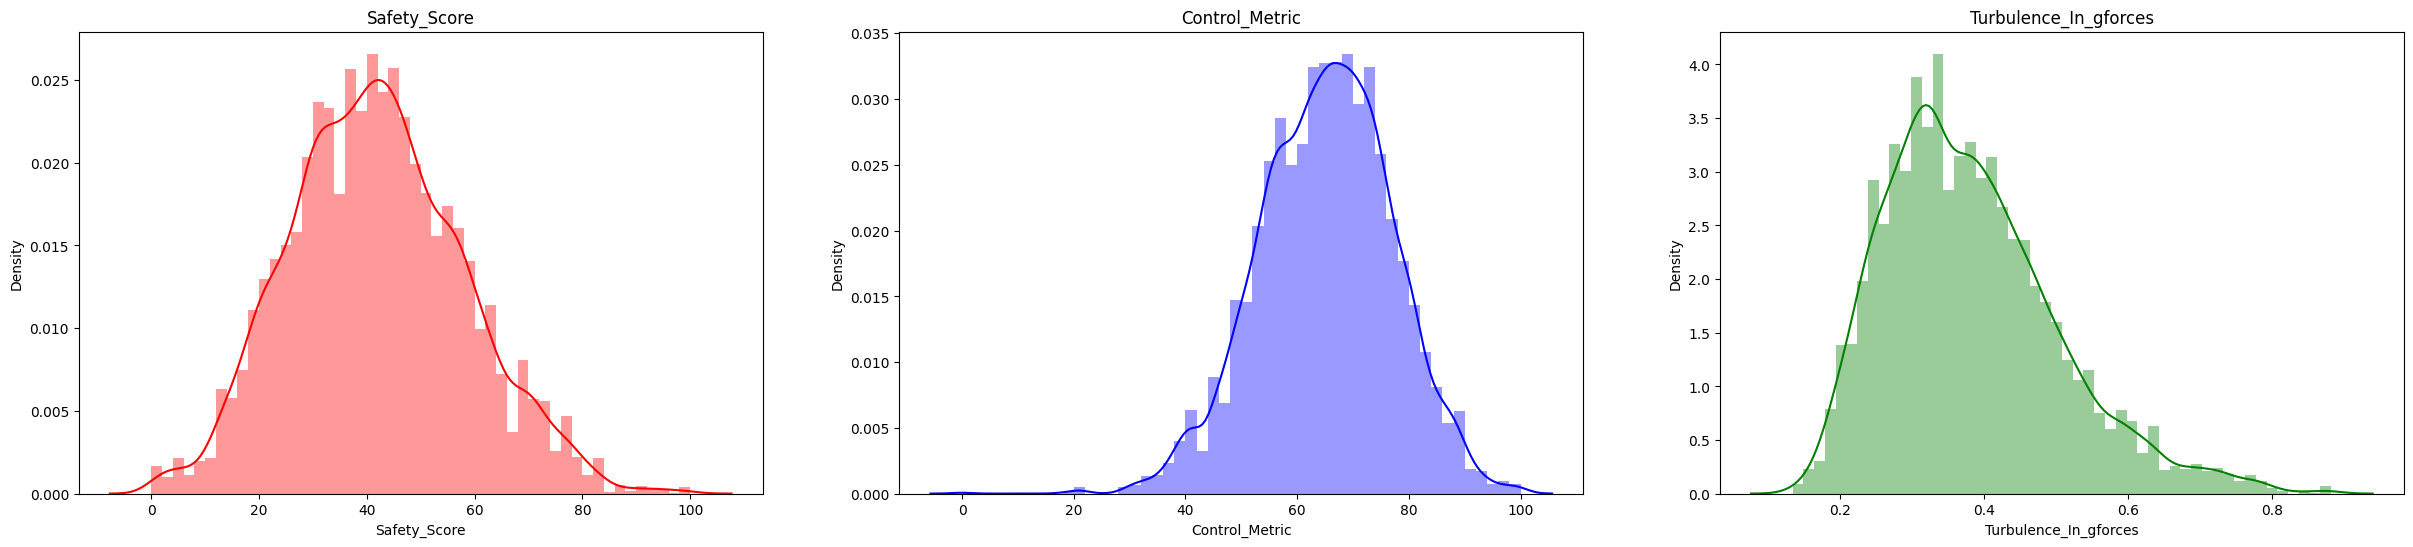

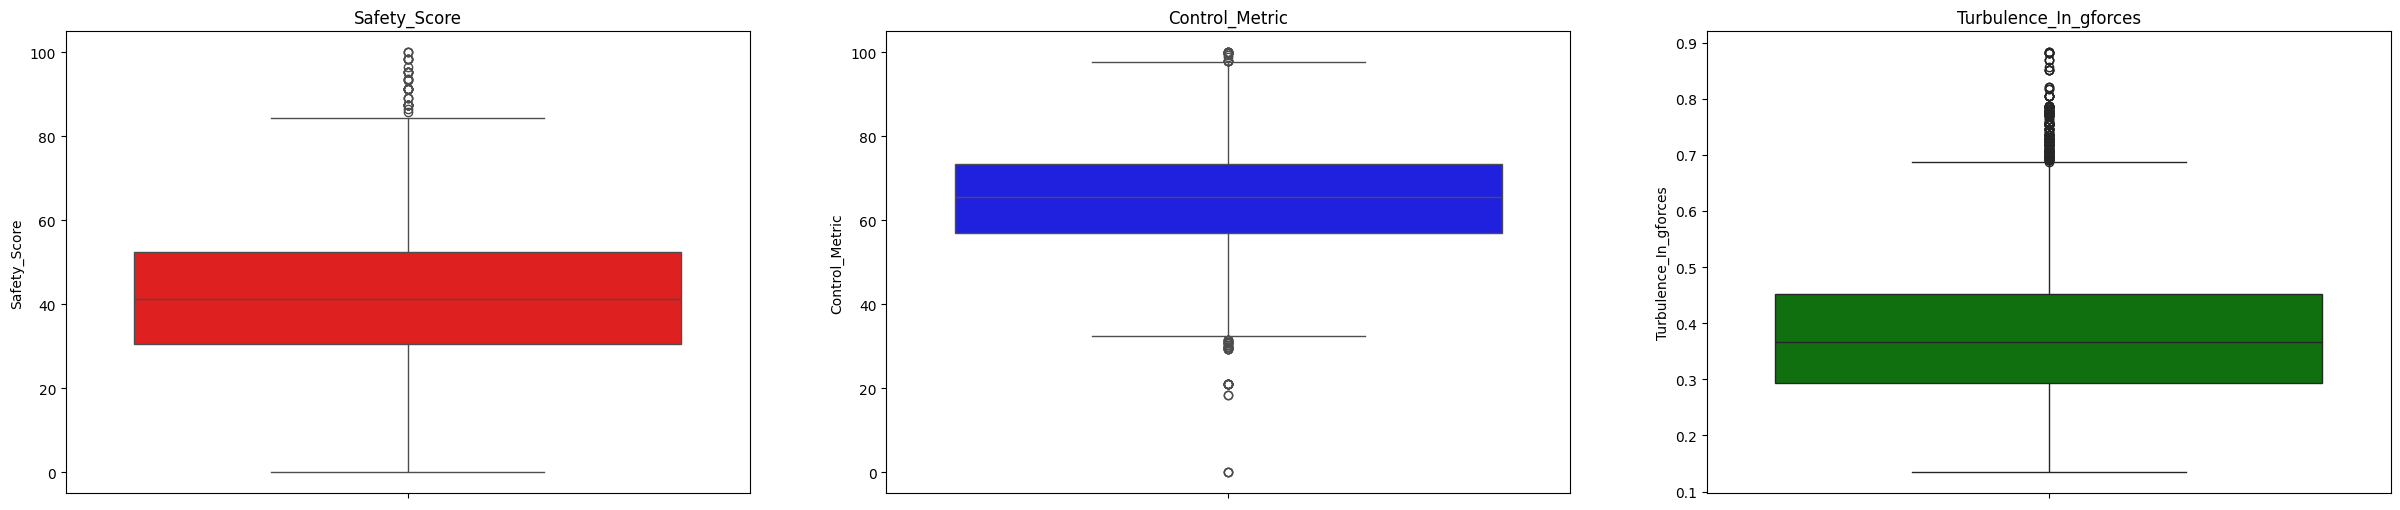

In [14]:
# Distribution of continous data

# Safety_Score, Control_Metric,Turbulence_In_gforce


plt.figure(figsize=(30,6))

#Subplot 1
plt.subplot(1,3,1)
plt.title('Safety_Score')
sns.distplot(data['Safety_Score'],color='red')

#Subplot 2
plt.subplot(1,3,2)
plt.title('Control_Metric')
sns.distplot(data['Control_Metric'],color='blue')

#Subplot 3
plt.subplot(1,3,3)
plt.title('Turbulence_In_gforces')
sns.distplot(data['Turbulence_In_gforces'],color='green')



plt.figure(figsize=(30,6))

#Subplot 1- Boxplot
plt.subplot(1,3,1)
plt.title('Safety_Score')
sns.boxplot(data['Safety_Score'],orient='horizondal',color='red')

#Subplot 2
plt.subplot(1,3,2)
plt.title('Control_Metric')
sns.boxplot(data['Control_Metric'],orient='horizondal',color='blue')

#Subplot 3
plt.subplot(1,3,3)
plt.title('Turbulence_In_gforces')
sns.boxplot(data['Turbulence_In_gforces'],orient='horizondal',color='green')


##### Safety score is normally distributed  and has few outliers
##### Control_Metric is skewed to the left but normally distributed with outliers
##### Turbulence_In_gForce is skewed to the left but normally distributed with outliers 

/var/folders/6z/g3z4qg6d1sjdr9x7v0zb708m0000gn/T/ipykernel_15392/3601504376.py:9: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data['Cabin_Temperature'],color='red')
/var/folders/6z/g3z4qg6d1sjdr9x7v0zb708m0000gn/T/ipykernel_15392/3601504376.py:14: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(

<Axes: title={'center': 'Adverse_Weather_Metric'}, ylabel='Adverse_Weather_Metric'>

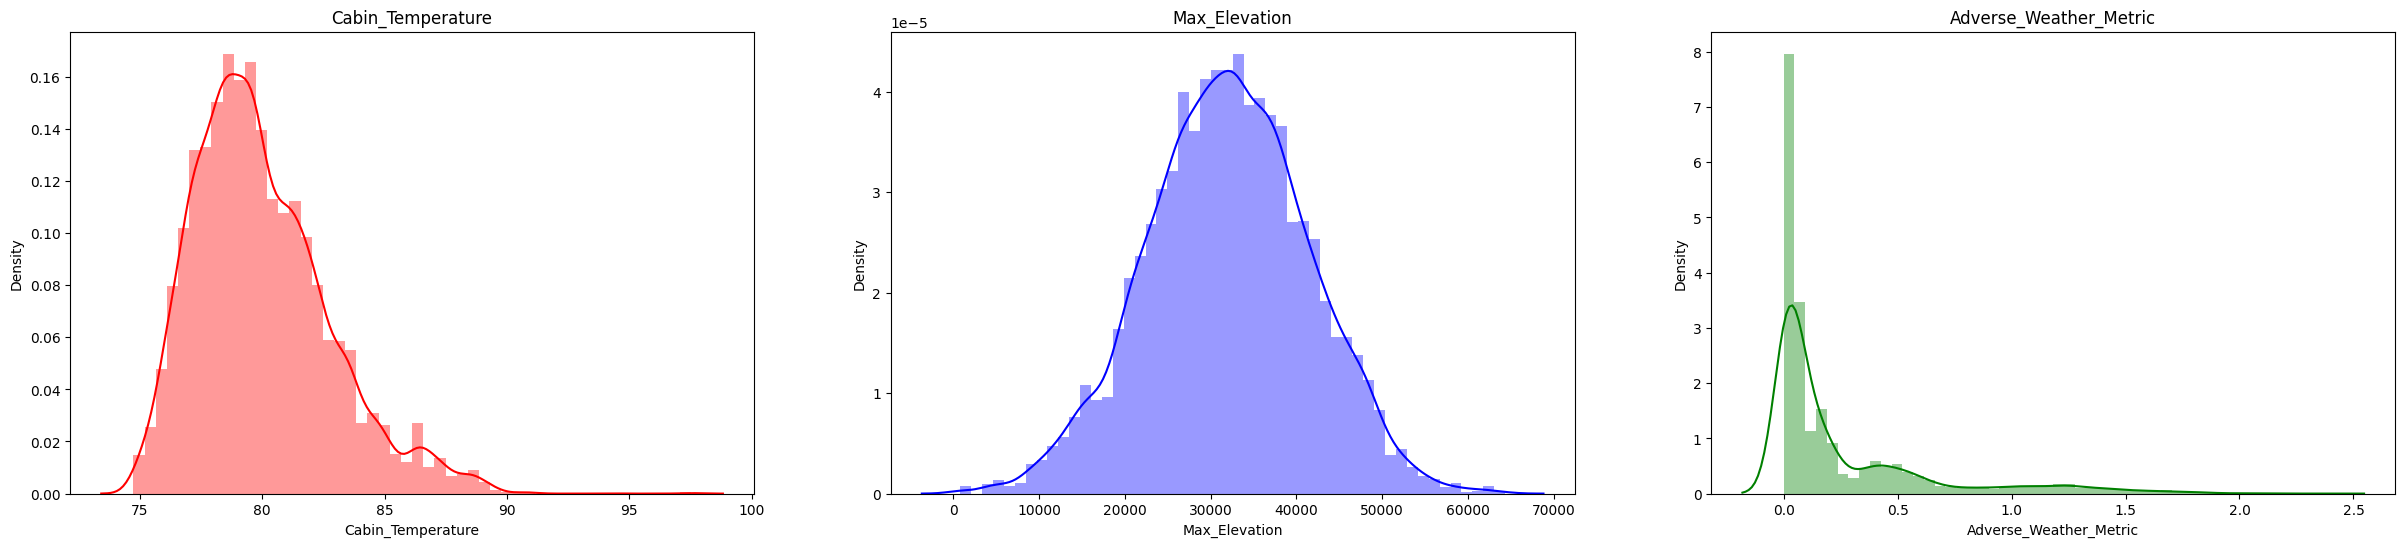

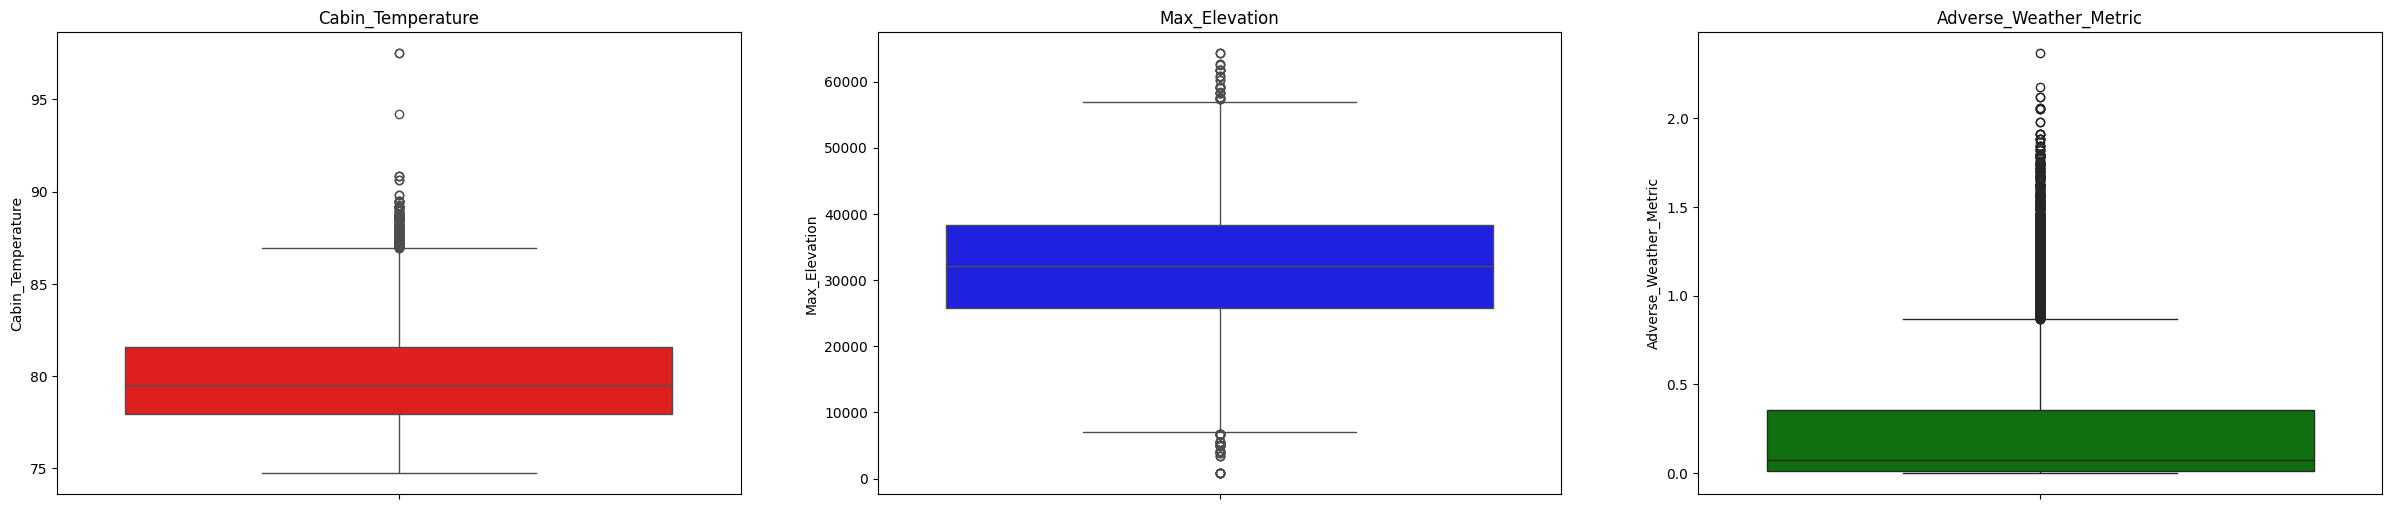

In [15]:
# Distribution of continous data
# Cabin_Temprature, Max_Elevation, Adverse_Weather_Metric

plt.figure(figsize=(30,6))

#Subplot 1
plt.subplot(1,3,1)
plt.title('Cabin_Temperature')
sns.distplot(data['Cabin_Temperature'],color='red')

#Subplot 2
plt.subplot(1,3,2)
plt.title('Max_Elevation')
sns.distplot(data['Max_Elevation'],color='blue')

#Subplot 3
plt.subplot(1,3,3)
plt.title('Adverse_Weather_Metric')
sns.distplot(data['Adverse_Weather_Metric'],color='green')



plt.figure(figsize=(30,6))

#Subplot 1- Boxplot
plt.subplot(1,3,1)
plt.title('Cabin_Temperature')
sns.boxplot(data['Cabin_Temperature'],orient='horizondal',color='red')

#Subplot 2
plt.subplot(1,3,2)
plt.title('Max_Elevation')
sns.boxplot(data['Max_Elevation'],orient='horizondal',color='blue')

#Subplot 3
plt.subplot(1,3,3)
plt.title('Adverse_Weather_Metric')
sns.boxplot(data['Adverse_Weather_Metric'],orient='horizondal',color='green')


##### Cabin_Temprature is skewed to the right but normally distributed with outliers
##### Max_Elevation is t normally distributed with outliers
##### Adverse_Weather_Metric is highly skewed to the right with huge number of outliers 

<Axes: title={'center': 'Total_Safety_Complaints'}, ylabel='count'>

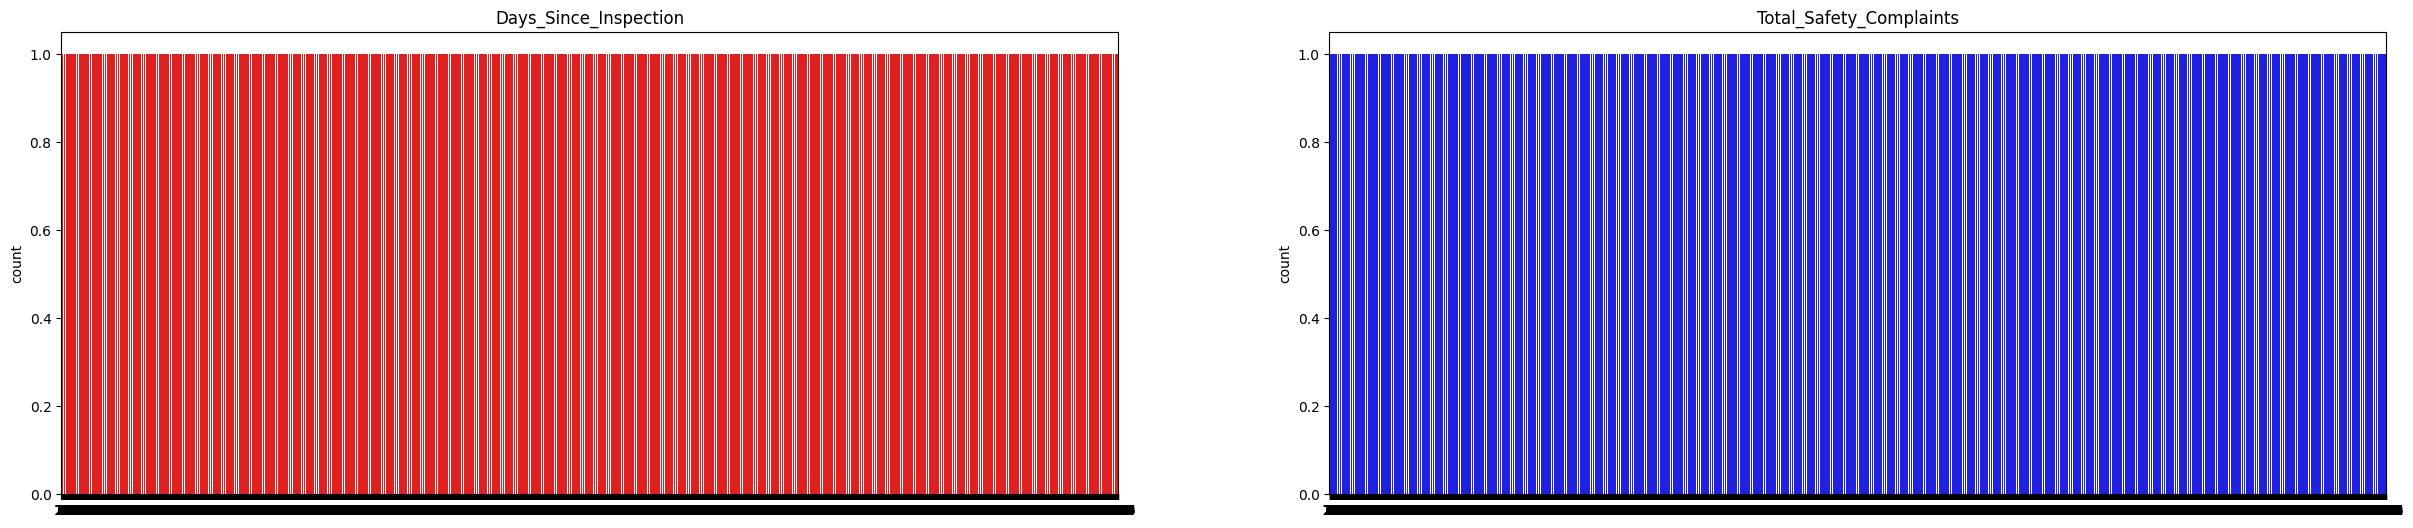

In [16]:
##### Days_Since_Inspection, Total_Safety_Compliant
plt.figure(figsize=(30,6))

#Subplot 1
plt.subplot(1,2,1)
plt.title('Days_Since_Inspection')
sns.countplot(data['Days_Since_Inspection'],color='red')

#Subplot 2
plt.subplot(1,2,2)
plt.title('Total_Safety_Complaints')
sns.countplot(data['Total_Safety_Complaints'],color='blue')


##### Average Days_Since_Inspection is 13
##### number of records with Total_Safety_Compliants as 0-10 is high

<Axes: title={'center': 'Violations'}, ylabel='count'>

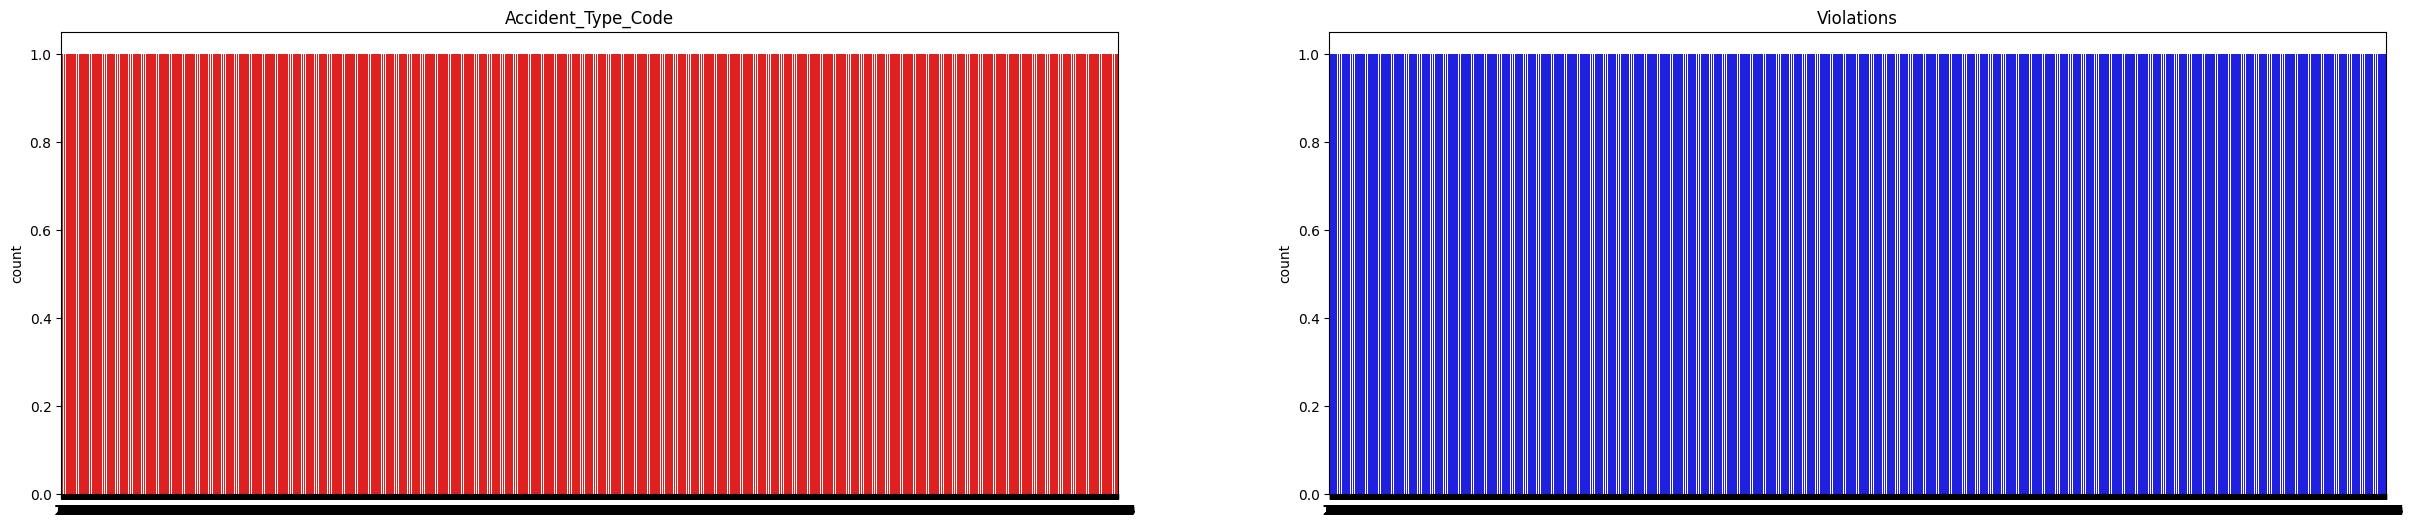

In [17]:
# Accident_Type_Code and Violations

plt.figure(figsize=(30,6))


#Subplot 1
plt.subplot(1,2,1)
plt.title('Accident_Type_Code')
sns.countplot(data['Accident_Type_Code'],color='red')

#Subplot 2
plt.subplot(1,2,2)
plt.title('Violations')
sns.countplot(data['Violations'],color='blue')

#####  Accident_Type_Code 5 has fewer number of records
##### 2 violations has the highest number of records

<Axes: title={'center': 'Severity'}, xlabel='count', ylabel='Severity'>

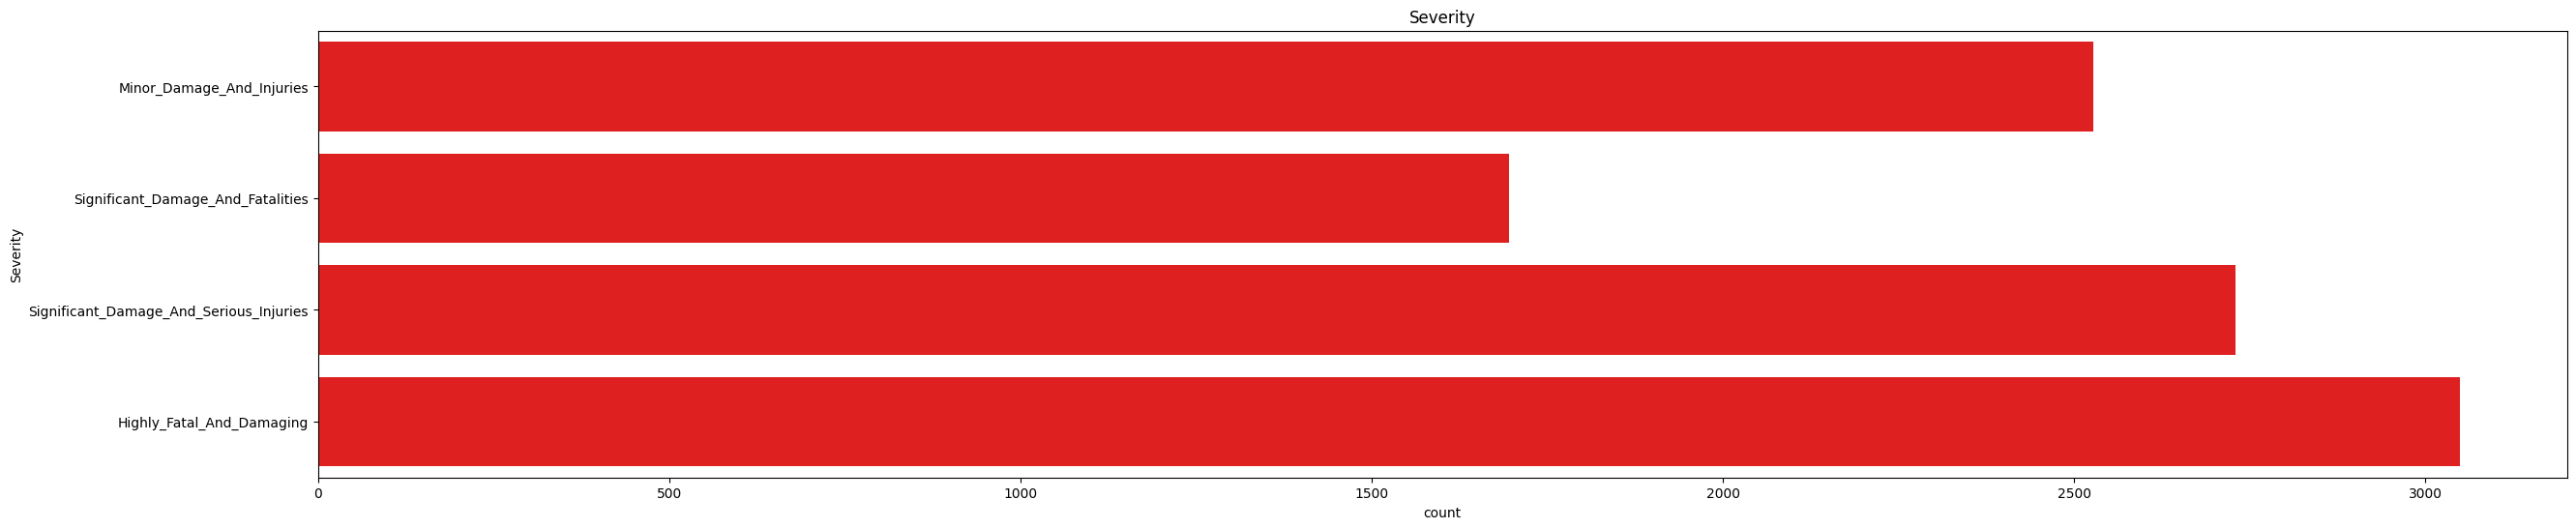

In [18]:
plt.figure(figsize=(30,6))

plt.title('Severity')
sns.countplot(data['Severity'],color='red')

#### There is a slight class imbalance with 'Significant_Damage_And_Fatalities' group having fewer number of records

#### Multi-variate Analysis

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/axisgrid.py:1513: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=vector, **plot_kwargs)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/axisgrid.py:1513: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=vector, **plot_kwargs)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/axisgrid.py:1513: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=vector, **plot_kwargs)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/axisgrid.py:1513: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=vector, **plot_kwargs)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/axisgrid.py:1513: UserWarning: Ignoring `palette` be

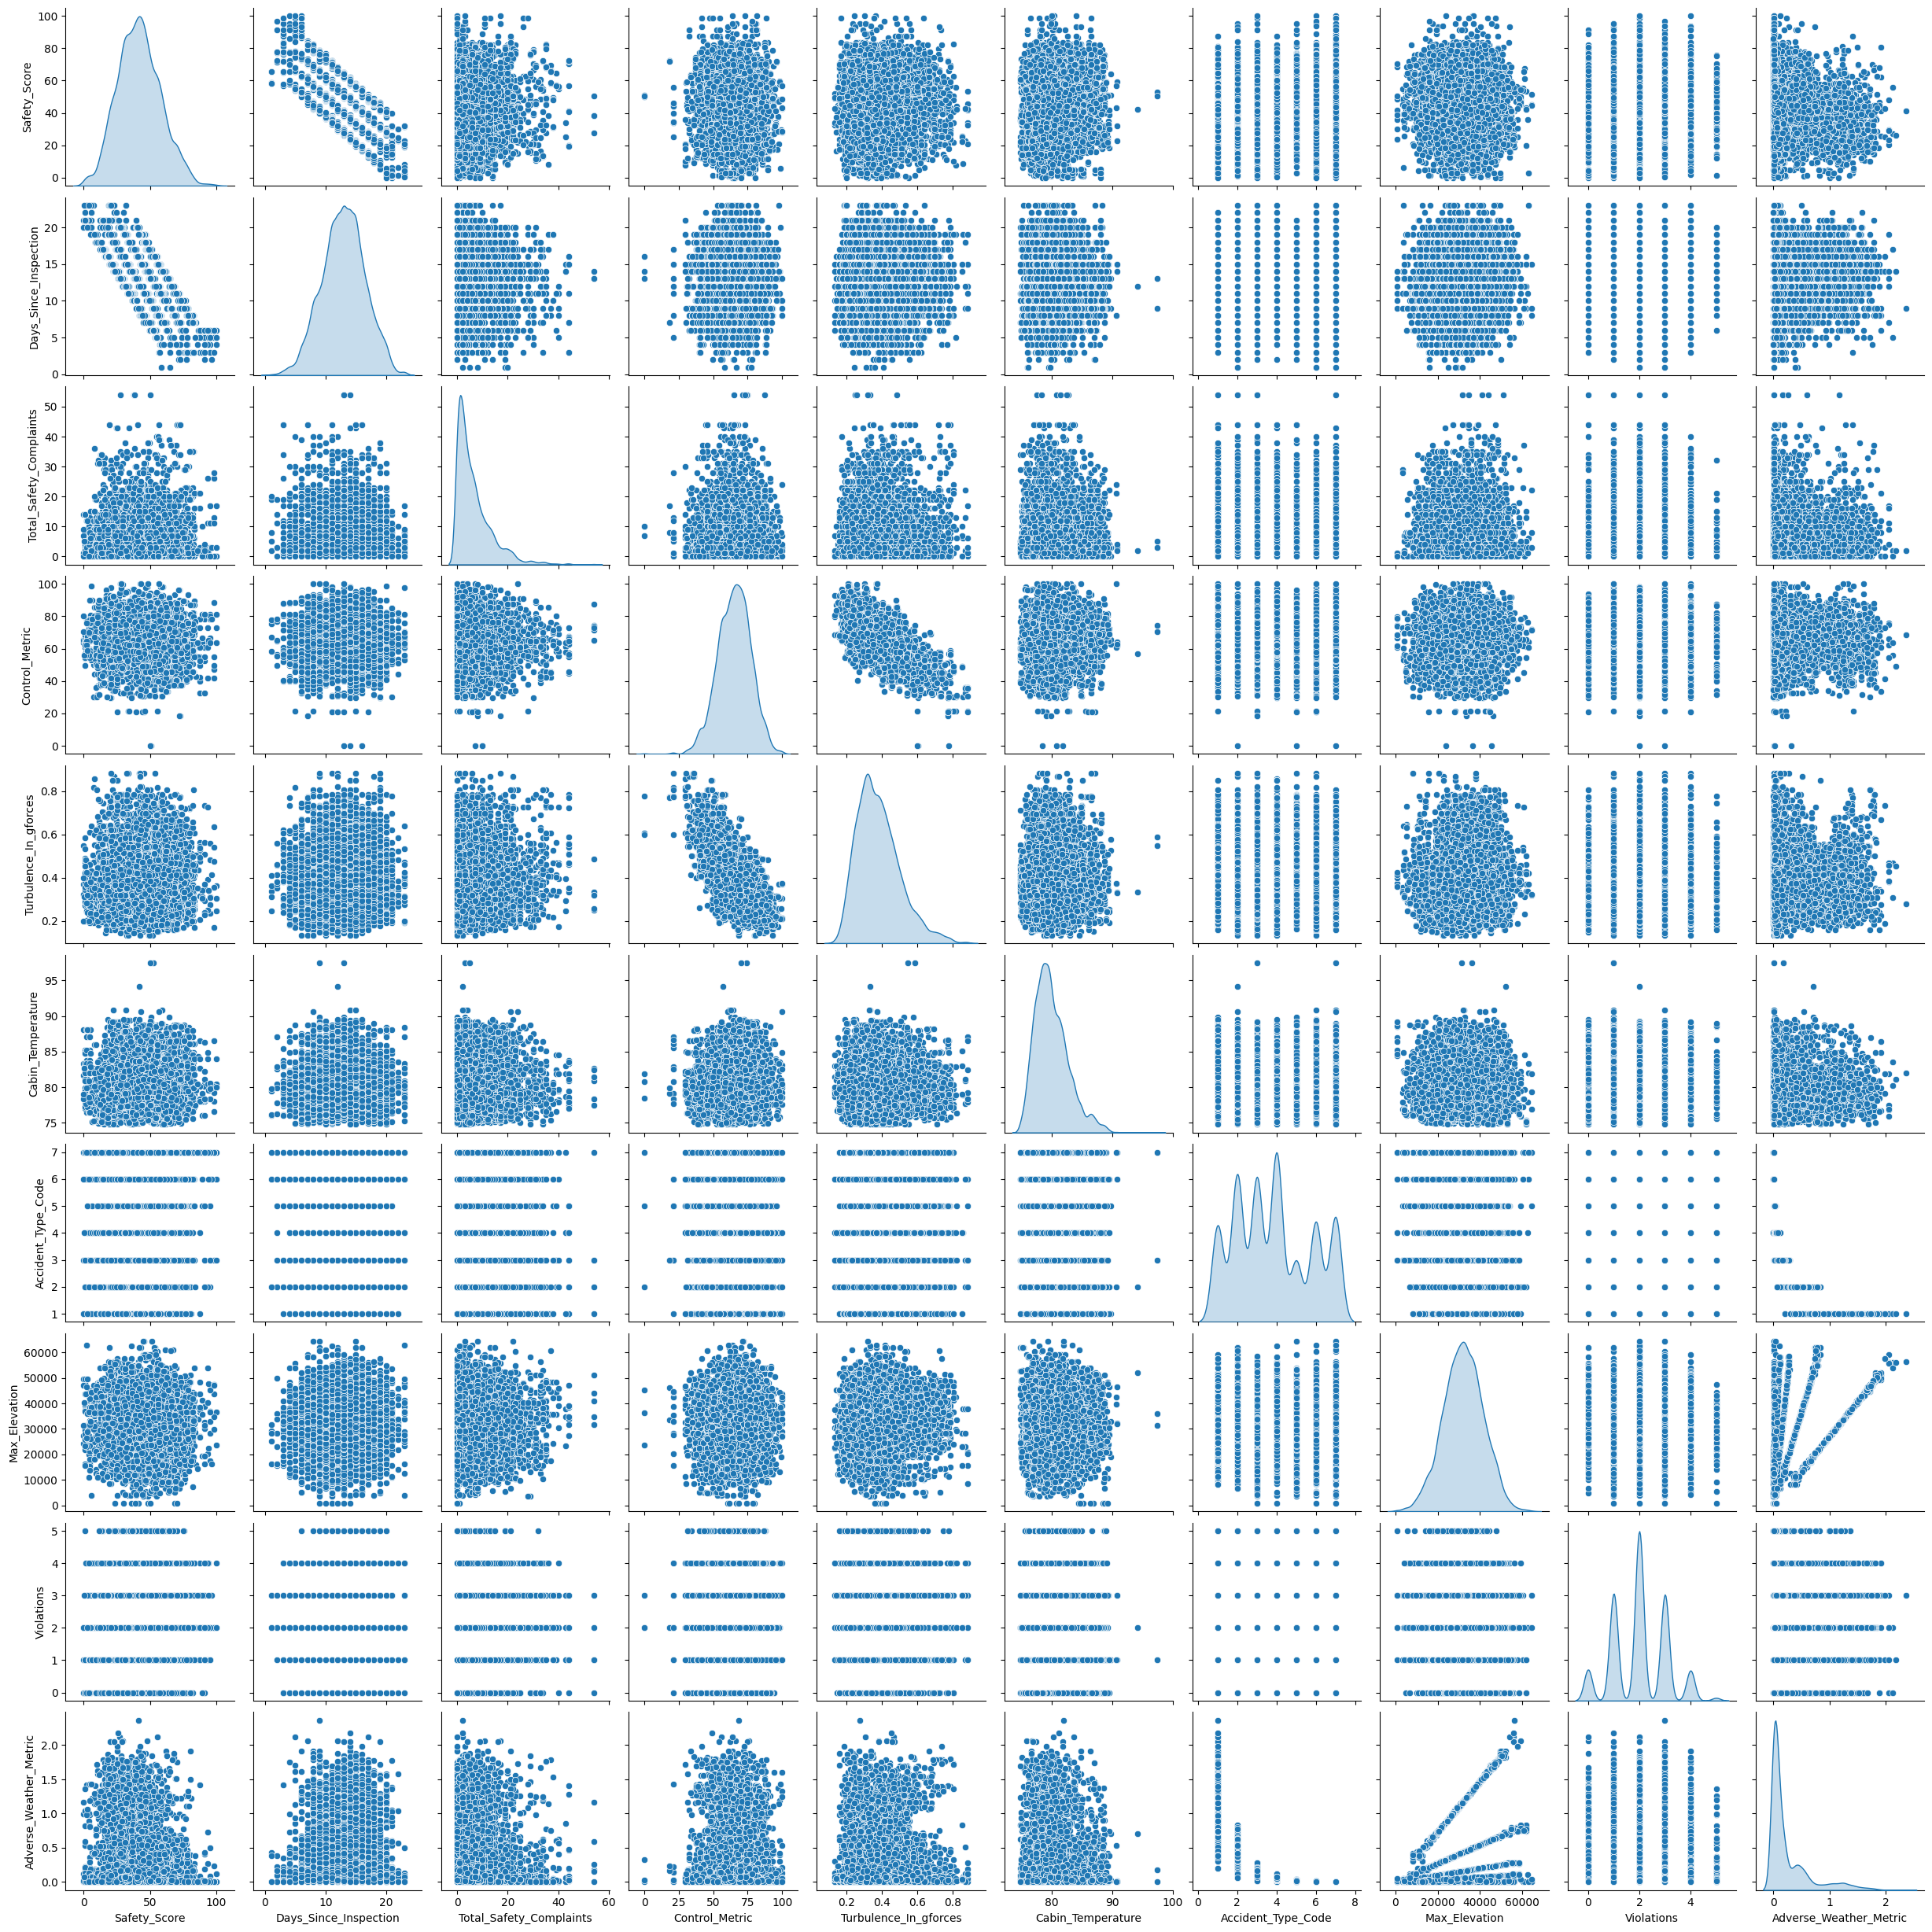

In [19]:
sns.pairplot(data,palette="Set2", diag_kind="kde", height=2.5)

#### Correlations

In [37]:
df=data.drop(['Severity'],axis=1)
def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, n=20):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

print("Top Absolute Correlations")
print(get_top_abs_correlations(df, 3))

Top Absolute Correlations
Accident_Type_Code  Adverse_Weather_Metric    0.739361
Safety_Score        Days_Since_Inspection     0.685386
Control_Metric      Turbulence_In_gforces     0.643285
dtype: float64


##### These pairs of independent attibutes have good correlation

#### Handle Outliers

In [38]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Severity                 10000 non-null  object 
 1   Safety_Score             10000 non-null  float64
 2   Days_Since_Inspection    10000 non-null  int64  
 3   Total_Safety_Complaints  10000 non-null  int64  
 4   Control_Metric           10000 non-null  float64
 5   Turbulence_In_gforces    10000 non-null  float64
 6   Cabin_Temperature        10000 non-null  float64
 7   Accident_Type_Code       10000 non-null  int64  
 8   Max_Elevation            10000 non-null  float64
 9   Violations               10000 non-null  int64  
 10  Adverse_Weather_Metric   10000 non-null  float64
dtypes: float64(6), int64(4), object(1)
memory usage: 859.5+ KB


In [39]:
dataNumericals = pd.DataFrame(data, columns =data.columns[data.dtypes == 'float64']) 
dataNumericals.head()

,Safety_Score,Control_Metric,Turbulence_In_gforces,Cabin_Temperature,Max_Elevation,Adverse_Weather_Metric
0,49.223744,71.285324,0.272118,78.04,31335.476824,0.424352
1,62.465753,72.288058,0.423939,84.54,26024.711057,0.352350
2,63.059361,66.362808,0.322604,78.86,39269.053927,0.003364
3,48.082192,74.703737,0.337029,81.79,42771.499200,0.211728
4,26.484018,47.948952,0.541140,77.16,35509.228515,0.176883


#### Applying z-score to scale the data and standardize the data


In [40]:
dataNumericals=dataNumericals.apply(zscore)

In [41]:
dataNumericals.head()

,Safety_Score,Control_Metric,Turbulence_In_gforces,Cabin_Temperature,Max_Elevation,Adverse_Weather_Metric
0,0.455303,0.516733,-0.901749,-0.699134,-0.070649,0.442701
1,1.275888,0.601122,0.349922,1.656279,-0.633736,0.253773
2,1.312673,0.102462,-0.485516,-0.401990,0.770528,-0.661939
3,0.384562,0.804422,-0.366593,0.659758,1.141883,-0.115208
4,-0.953841,-1.447221,1.316177,-1.018021,0.371883,-0.206638


#### Removing all records with z-score greater and lesser than 3 and -3 respectivley as the values are outliers

In [42]:
floats = dataNumericals.columns[dataNumericals.dtypes == 'float64']
for columns in floats:
    indexNames_larger = dataNumericals[dataNumericals[columns]>3].index
    indexNames_lesser = dataNumericals[dataNumericals[columns]<-3].index
    # Delete these row indexes from dataFrame
    dataNumericals.drop(indexNames_larger , inplace=True)
    dataNumericals.drop(indexNames_lesser , inplace=True)
    data.drop(indexNames_larger , inplace=True)
    data.drop(indexNames_lesser , inplace=True)

In [43]:
dataNumericals.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9507 entries, 0 to 9999
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Safety_Score            9507 non-null   float64
 1   Control_Metric          9507 non-null   float64
 2   Turbulence_In_gforces   9507 non-null   float64
 3   Cabin_Temperature       9507 non-null   float64
 4   Max_Elevation           9507 non-null   float64
 5   Adverse_Weather_Metric  9507 non-null   float64
dtypes: float64(6)
memory usage: 519.9 KB


In [44]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9507 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Severity                 9507 non-null   object 
 1   Safety_Score             9507 non-null   float64
 2   Days_Since_Inspection    9507 non-null   int64  
 3   Total_Safety_Complaints  9507 non-null   int64  
 4   Control_Metric           9507 non-null   float64
 5   Turbulence_In_gforces    9507 non-null   float64
 6   Cabin_Temperature        9507 non-null   float64
 7   Accident_Type_Code       9507 non-null   int64  
 8   Max_Elevation            9507 non-null   float64
 9   Violations               9507 non-null   int64  
 10  Adverse_Weather_Metric   9507 non-null   float64
dtypes: float64(6), int64(4), object(1)
memory usage: 891.3+ KB


#### 493 records were removed as they were considered outliers

#### Merging the scaled columns back to the original dataframe

In [45]:
data.drop(data.columns[data.dtypes == 'float64'],axis=1,inplace=True)

In [46]:
data.head()

,Severity,Days_Since_Inspection,Total_Safety_Complaints,Accident_Type_Code,Violations
0,Minor_Damage_And_Injuries,14,22,2,3
1,Minor_Damage_And_Injuries,10,27,2,2
2,Significant_Damage_And_Fatalities,13,16,7,3
3,Significant_Damage_And_Serious_Injuries,11,9,3,1
4,Significant_Damage_And_Fatalities,13,25,3,2


In [47]:
for column in dataNumericals.columns:
    data[column]=dataNumericals[column]

In [48]:
data.head()

,Severity,Days_Since_Inspection,Total_Safety_Complaints,Accident_Type_Code,Violations,Safety_Score,Control_Metric,Turbulence_In_gforces,Cabin_Temperature,Max_Elevation,Adverse_Weather_Metric
0,Minor_Damage_And_Injuries,14,22,2,3,0.455303,0.516733,-0.901749,-0.699134,-0.070649,0.442701
1,Minor_Damage_And_Injuries,10,27,2,2,1.275888,0.601122,0.349922,1.656279,-0.633736,0.253773
2,Significant_Damage_And_Fatalities,13,16,7,3,1.312673,0.102462,-0.485516,-0.401990,0.770528,-0.661939
3,Significant_Damage_And_Serious_Injuries,11,9,3,1,0.384562,0.804422,-0.366593,0.659758,1.141883,-0.115208
4,Significant_Damage_And_Fatalities,13,25,3,2,-0.953841,-1.447221,1.316177,-1.018021,0.371883,-0.206638


In [49]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9507 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Severity                 9507 non-null   object 
 1   Days_Since_Inspection    9507 non-null   int64  
 2   Total_Safety_Complaints  9507 non-null   int64  
 3   Accident_Type_Code       9507 non-null   int64  
 4   Violations               9507 non-null   int64  
 5   Safety_Score             9507 non-null   float64
 6   Control_Metric           9507 non-null   float64
 7   Turbulence_In_gforces    9507 non-null   float64
 8   Cabin_Temperature        9507 non-null   float64
 9   Max_Elevation            9507 non-null   float64
 10  Adverse_Weather_Metric   9507 non-null   float64
dtypes: float64(6), int64(4), object(1)
memory usage: 891.3+ KB


#### Label Encoding the Target Column

In [50]:
data['Severity'].unique()

array(['Minor_Damage_And_Injuries', 'Significant_Damage_And_Fatalities',
       'Significant_Damage_And_Serious_Injuries',
       'Highly_Fatal_And_Damaging'], dtype=object)

In [51]:
encoder=LabelEncoder()
data['Severity']=encoder.fit_transform(data['Severity'])

In [52]:
data.head()

,Severity,Days_Since_Inspection,Total_Safety_Complaints,Accident_Type_Code,Violations,Safety_Score,Control_Metric,Turbulence_In_gforces,Cabin_Temperature,Max_Elevation,Adverse_Weather_Metric
0,1,14,22,2,3,0.455303,0.516733,-0.901749,-0.699134,-0.070649,0.442701
1,1,10,27,2,2,1.275888,0.601122,0.349922,1.656279,-0.633736,0.253773
2,2,13,16,7,3,1.312673,0.102462,-0.485516,-0.401990,0.770528,-0.661939
3,3,11,9,3,1,0.384562,0.804422,-0.366593,0.659758,1.141883,-0.115208
4,2,13,25,3,2,-0.953841,-1.447221,1.316177,-1.018021,0.371883,-0.206638


### Feature Engineering

In [54]:
data['Total_Safety_Complaints'] = np.power(2, data['Total_Safety_Complaints'])
data['Days_Since_Inspection'] = np.power(2, data['Days_Since_Inspection'])
data['Safety_Score'] = np.power(2, data['Safety_Score'])

#### Splitting X-independent attributes and Y-dependent attributes and keeping the test set seperate
#### Creating multiple cross-validation to reduce overfitting

In [55]:
X=data.drop(['Severity'],axis=1)

In [56]:
Y=data['Severity']

In [57]:
Xtrain_val,X_test,ytrain_val,Y_test=train_test_split(X,Y,test_size=0.2,random_state=22)

In [58]:
kf = KFold(n_splits=10,random_state=2,shuffle=True)
kf.get_n_splits(Xtrain_val)
print(kf)


for train_index, val_index in kf.split(Xtrain_val):
    print("TRAIN:", train_index, "VALIDATION:", val_index)
    X_train, X_val = Xtrain_val.iloc[train_index], Xtrain_val.iloc[val_index]
    y_train, y_val = ytrain_val.iloc[train_index], ytrain_val.iloc[val_index]

KFold(n_splits=10, random_state=2, shuffle=True)
TRAIN: [   0    1    2 ... 7602 7603 7604] VALIDATION: [   3    4   20   37   62   81   88  103  110  128  129  130  145  153
  179  185  186  194  201  202  207  213  222  256  273  275  288  291
  315  338  363  367  368  379  380  391  426  458  460  472  489  497
  500  521  545  562  564  565  577  586  595  604  606  612  642  649
  659  661  663  680  688  689  701  721  723  727  739  740  742  749
  753  761  793  810  814  829  837  838  840  844  849  857  866  885
  887  889  891  916  925  942  946  948  954  955  958  959  972 1006
 1019 1022 1030 1031 1067 1104 1109 1116 1125 1139 1142 1145 1146 1164
 1168 1182 1196 1208 1209 1219 1228 1229 1230 1249 1259 1260 1263 1281
 1290 1291 1300 1301 1330 1338 1346 1380 1383 1395 1402 1406 1409 1411
 1440 1451 1457 1475 1493 1494 1504 1521 1527 1539 1540 1543 1547 1549
 1553 1558 1561 1565 1605 1608 1619 1664 1666 1667 1668 1678 1685 1703
 1737 1744 1754 1757 1760 1764 1778 1783 179